In [1]:
import numpy as np
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, OperatorStateFn
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.join("..", "..","src"))
from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds

# Set a random seed
np.random.seed(42)

In [2]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)

In [3]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [6]:
from qiskit_machine_learning.neural_networks import OpflowQNN

In [4]:
inputs = ParameterVector('input', length=4) # 1 extra for label
# inputs = ParameterVector('input', length=3)
weights = ParameterVector('weight', length=20)

# 1qubit classifier
qc1 = QuantumCircuit(1)

qc1.rz(inputs[0]*weights[0]+inputs[1]*weights[1]+inputs[2]*weights[2] + weights[3],0)
qc1.ry(weights[4],0)
qc1.rz(inputs[0]*weights[5]+inputs[1]*weights[6]+inputs[2]*weights[7] + weights[8],0)
qc1.ry(weights[9],0)
qc1.rz(inputs[0]*weights[10]+inputs[1]*weights[11]+inputs[2]*weights[12] + weights[13],0)
qc1.ry(weights[14],0)
qc1.rz(inputs[0]*weights[15]+inputs[1]*weights[16]+inputs[2]*weights[17] + weights[18],0)
qc1.ry(weights[19],0)
qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0)]))  
H2 = StateFn(PauliSumOp.from_list([('Z', -1.0)]))  

op1 = ~H1 @ (qc_sfn1)
op2 = ~H2 @ (qc_sfn1)
print(op1)
print(len(weights))

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       »
  q_0: »
       »
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[0] + input[1]*weight[1] + input[2]*weight[2] + weight[3]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[4]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[5] + input[1]*weight[6] + input[2]*weight[7] + weight[8]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[9]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[10] + input[1]*weight[11] + input[2]*weight[12] + weight[13]) ├»
  «     └───────────

In [7]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, inputs, weights, expval, gradient, qi_sv, input_gradients=True)
qnn2 = OpflowQNN(op2, inputs, weights, expval, gradient, qi_sv, input_gradients=True)

In [8]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit.utils import algorithm_globals

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [20]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)
# fit_result = optimizer.minimize(
fit_result = optimizer.optimize( 
    num_vars=qnn1.num_weights,
    objective_function=function.objective,
    initial_point=algorithm_globals.random.random(qnn1.num_weights),
    gradient_function=function.gradient,
)

print(fit_result)

<bound method BinaryObjectiveFunction.gradient of <__main__.BinaryObjectiveFunction object at 0x0000027C9868F820>>
weights:  [0.02789309 0.21504061 0.73727504 0.57121112 0.50674504 0.86440762
 0.25242903 0.97108245 0.55533286 0.59575185 0.9907266  0.26430439
 0.34817704 0.92542748 0.25033864 0.34221529 0.43078997 0.85939455
 0.08627822 0.70873382]
loss:  1.4323937717558823
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112 -0.05533707  0.55721048
  0.34772654  0.97108245  0.66397298  0.51419224  0.43453256  0.41653349
  0.34817704  0.94048287  0.28446287 -0.12217579  0.52631365  0.85939455
  0.1004529   0.65167287]
loss:  1.1937995337776035
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112 -0.43546644  0.34745498
  0.41336738  0.97108245  0.7455166   0.60488038  0.02736845  0.4925853
  0.34817704  0.8866612   0.52802165 -0.4543101   0.55212644  0.85939455
  0.06175662  0.82401624]
loss:  1.1183222992378332
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112 -0.1

loss:  0.34377986528146454
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112  1.81184876  1.90835757
  1.098575    0.97108245 -0.14032758  1.51504383 -2.68109647  0.35690061
  0.34817704  0.03080352  1.62835343  1.64141558 -1.43401115  0.85939455
  0.07090582  1.47052767]
loss:  0.33268038070195266
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112  1.86386574  1.98769176
  0.98652627  0.97108245 -0.1158391   1.58348054 -2.68804112  0.46358063
  0.34817704  0.02961671  1.62109792  1.68993935 -1.47906616  0.85939455
  0.02651841  1.43001612]
loss:  0.32720991788514325
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112  1.85658835  1.98965724
  0.85930734  0.97108245 -0.08709319  1.60411886 -2.60515339  0.58236429
  0.34817704  0.02379938  1.6330712   1.66890536 -1.50751924  0.85939455
  0.01943008  1.37934237]
loss:  0.3203974845186089
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112  1.86779666  1.93140092
  0.43332622  0.97108245  0.03728275  1.70092

loss:  0.2680308638105861
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112  1.61946097  2.09090695
  0.3260885   0.97108245 -0.05456409  1.83059016 -1.92525518  1.56797047
  0.34817704 -0.08123239  1.86052288  0.73009376 -1.8025677   0.85939455
  0.05441661  1.31487572]
loss:  0.26794913718349717
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112  1.6256747   2.10980745
  0.30367749  0.97108245 -0.05661009  1.79952823 -1.96620524  1.61185468
  0.34817704 -0.0784738   1.8441424   0.69007844 -1.75918722  0.85939455
  0.05674323  1.35273964]
loss:  0.26782240110541267
weights:  [ 0.02789309  0.21504061  0.73727504  0.57121112  1.62060383  2.13768458
  0.27493774  0.97108245 -0.06248834  1.78537778 -1.9804381   1.65927674
  0.34817704 -0.08576099  1.82218078  0.64640015 -1.72936424  0.85939455
  0.05511248  1.39264709]
loss:  0.2677035470550017
(array([ 0.02789309,  0.21504061,  0.73727504,  0.57121112,  1.62060383,
        2.13768458,  0.27493774,  0.97108245, -0.0624883

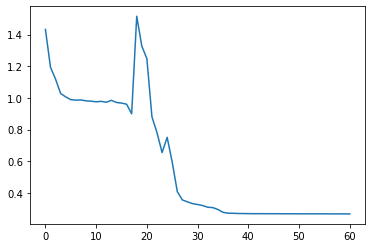

In [21]:
plt.plot(losses)

In [23]:
ws = [ 0.02789309,  0.21504061,  0.73727504,  0.57121112,  1.62060383,
        2.13768458,  0.27493774,  0.97108245, -0.06248834,  1.78537778,
       -1.9804381 ,  1.65927674,  0.34817704, -0.08576099,  1.82218078,
        0.64640015, -1.72936424,  0.85939455,  0.05511248,  1.39264709]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

0.945


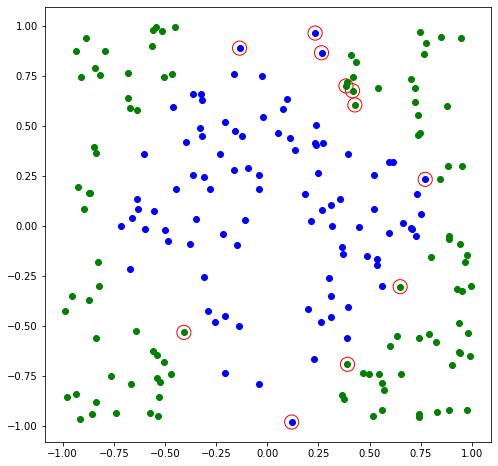

In [24]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [25]:

y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_test, qnn1, ws)

0.882


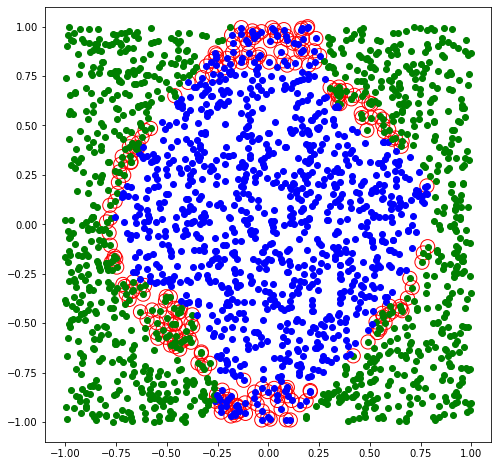

In [26]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()